# Coconut Caterpillar Detection Model v2 - Final Results

This notebook presents the final results of the Coconut Caterpillar Detection Model v2, which uses:

- **Architecture:** MobileNetV2 (Transfer Learning)
- **Loss Function:** Focal Loss (gamma=2.0) for handling class imbalance
- **Training Strategy:** 2-phase training (frozen base → fine-tuning)
- **Classes:** 3 (caterpillar, healthy, not_coconut)

**Key Improvements over v1:**
- Added `not_coconut` class for proper image validation
- Focal Loss for better handling of hard examples
- 2-phase training with fine-tuning

## 1. Setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display

print(f"TensorFlow version: {tf.__version__}")

# Paths
BASE_DIR = os.path.abspath('..')
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'coconut_caterpillar_v2')
DATA_DIR = os.path.join(BASE_DIR, 'data', 'raw', 'pest_caterpillar', 'dataset')
TEST_DIR = os.path.join(DATA_DIR, 'test')

IMG_SIZE = 224
BATCH_SIZE = 32
class_names = ['caterpillar', 'healthy', 'not_coconut']

TensorFlow version: 2.20.0


## 2. Training History

TRAINING SUMMARY

  Model: coconut_caterpillar_3class_v2
  Architecture: MobileNetV2 (Fine-tuned)
  Classes: ['caterpillar', 'healthy', 'not_coconut']

  Training Configuration:
  --------------------------------------------------
  Phase 1 (Frozen Base):    15 epochs
  Phase 2 (Fine-tuning):    15 epochs
  Total Epochs:             30 epochs
  Training Time:            196.7 minutes

  Final Metrics:
  --------------------------------------------------
  Train Accuracy:           99.73%
  Validation Accuracy:      97.91%

  Training History Plot:


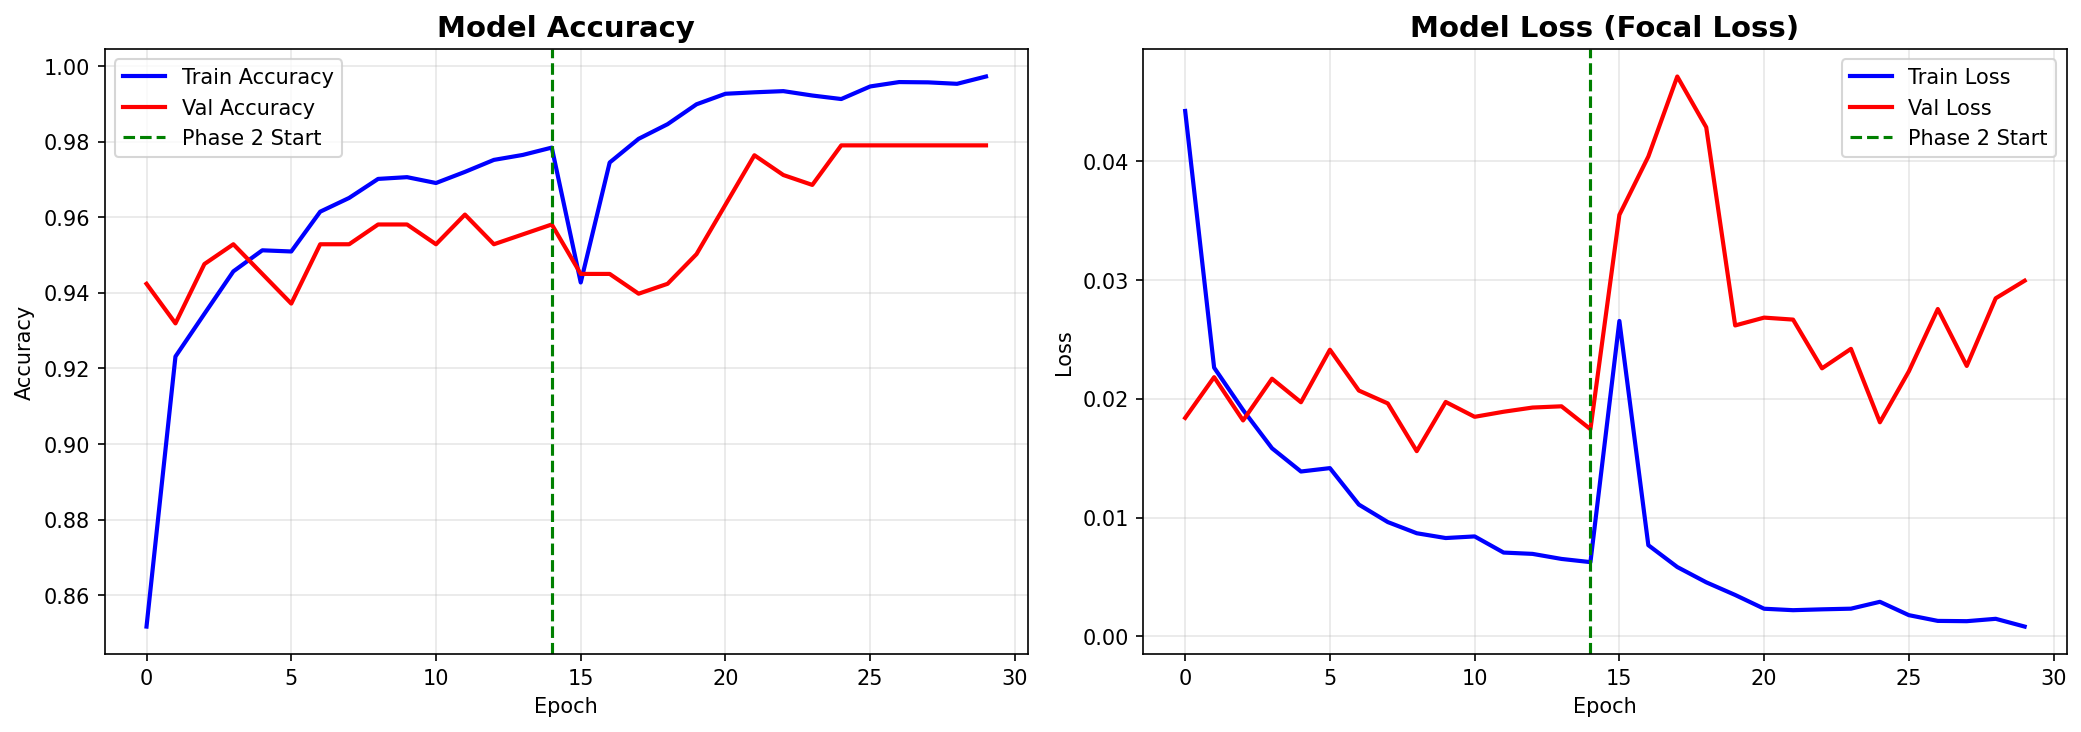

In [2]:
# Load model info
model_info_path = os.path.join(MODEL_DIR, 'model_info.json')
with open(model_info_path, 'r') as f:
    model_info = json.load(f)

print("="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"\n  Model: {model_info.get('model_name', 'caterpillar_3class_v2')}")
print(f"  Architecture: {model_info.get('architecture', 'MobileNetV2')}")
print(f"  Classes: {model_info.get('classes', class_names)}")
print()

training = model_info.get('training', {})
print(f"  Training Configuration:")
print(f"  " + "-"*50)
print(f"  Phase 1 (Frozen Base):    {training.get('phase1_epochs', 15)} epochs")
print(f"  Phase 2 (Fine-tuning):    {training.get('phase2_epochs', 15)} epochs")
print(f"  Total Epochs:             {training.get('total_epochs', 30)} epochs")
print(f"  Training Time:            {training.get('training_time_minutes', 196.7):.1f} minutes")
print()
print(f"  Final Metrics:")
print(f"  " + "-"*50)
print(f"  Train Accuracy:           {training.get('final_train_accuracy', 0.9973)*100:.2f}%")
print(f"  Validation Accuracy:      {training.get('final_val_accuracy', 0.9791)*100:.2f}%")
print("="*70)

# Display training history plot
print("\n  Training History Plot:")
history_img_path = os.path.join(MODEL_DIR, 'training_history.png')
if os.path.exists(history_img_path):
    display(Image(filename=history_img_path))

## 3. Load Model

In [3]:
# Custom focal loss for loading the model
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.keras.backend.log(y_pred)
        focal_weight = tf.keras.backend.pow(1.0 - y_pred, gamma)
        focal_loss = alpha * focal_weight * cross_entropy
        return tf.keras.backend.sum(focal_loss, axis=-1)
    return focal_loss_fn

# Load the trained model
model_path = os.path.join(MODEL_DIR, 'best_model.keras')
model = tf.keras.models.load_model(
    model_path,
    custom_objects={'focal_loss_fn': focal_loss(gamma=2.0, alpha=0.25)}
)

print("Model loaded successfully!")
print(f"Model summary:")
model.summary()

Model loaded successfully!
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 5,828,043 (22.23 MB)

 Trainable params: 1,698,819 (6.48 MB)

 Non-trainable params: 731,584 (2.79 MB)

 Optimizer params: 3,397,640 (12.96 MB)

## 4. Sample Images from Each Class

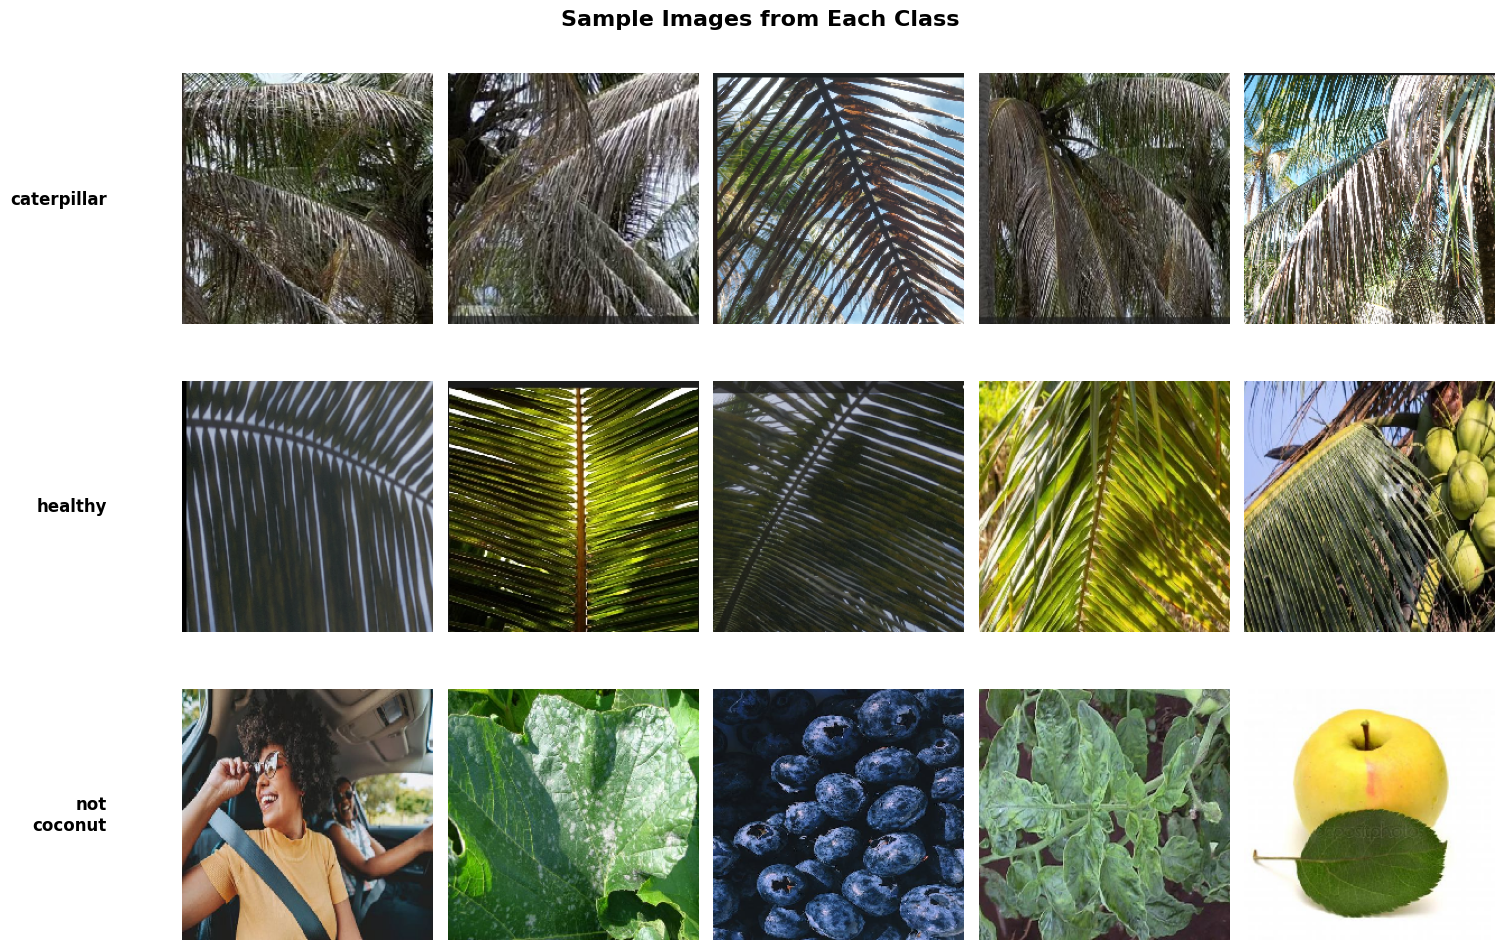


Sample images saved to: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_caterpillar_v2/sample_images.png


In [4]:
from tensorflow.keras.preprocessing import image
import random

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for row, cls in enumerate(class_names):
    cls_dir = os.path.join(TEST_DIR, cls)
    images_list = os.listdir(cls_dir)
    
    # Get 5 random images
    sample_imgs = random.sample(images_list, min(5, len(images_list)))
    
    for col, img_name in enumerate(sample_imgs):
        img_path = os.path.join(cls_dir, img_name)
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    
    # Add class label on the left
    axes[row, 0].text(-0.3, 0.5, cls.replace('_', '\n'), transform=axes[row, 0].transAxes,
                      fontsize=12, fontweight='bold', va='center', ha='right')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"\nSample images saved to: {MODEL_DIR}/sample_images.png")

## 5. Load Test Data

In [5]:
# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

print(f"\nTest set: {test_generator.samples} images")
print(f"Classes: {class_names}")

# Count per class
for cls in class_names:
    cls_dir = os.path.join(TEST_DIR, cls)
    count = len(os.listdir(cls_dir))
    print(f"  {cls}: {count} images")

Found 277 images belonging to 3 classes.



Test set: 277 images
Classes: ['caterpillar', 'healthy', 'not_coconut']
  caterpillar: 47 images
  healthy: 45 images
  not_coconut: 185 images


## 6. Evaluate Model

In [6]:
# Make predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(y_true == y_pred)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

1/9 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step

2/9 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step

3/9 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step

4/9 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step

5/9 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step

6/9 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step

7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step

8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 634ms/step



Test Accuracy: 97.47%


## 7. Final Results

In [7]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Calculate metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
macro_f1 = np.mean(f1)

print("="*70)
print("FINAL RESULTS - Caterpillar Model v2")
print("="*70)
print(f"\nOverall Accuracy: {accuracy*100:.2f}%")
print(f"Macro F1 Score: {macro_f1*100:.2f}%")
print(f"\n{'Class':<20} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("-"*70)

for i, cls in enumerate(class_names):
    print(f"{cls:<20} {precision[i]*100:>11.2f}% {recall[i]*100:>11.2f}% {f1[i]*100:>11.2f}%")

print("="*70)

FINAL RESULTS - Caterpillar Model v2

Overall Accuracy: 97.47%
Macro F1 Score: 96.30%

Class                   Precision       Recall     F1-Score
----------------------------------------------------------------------
caterpillar                97.73%       91.49%       94.51%
healthy                    91.84%      100.00%       95.74%
not_coconut                98.91%       98.38%       98.64%


## 8. Confusion Matrix

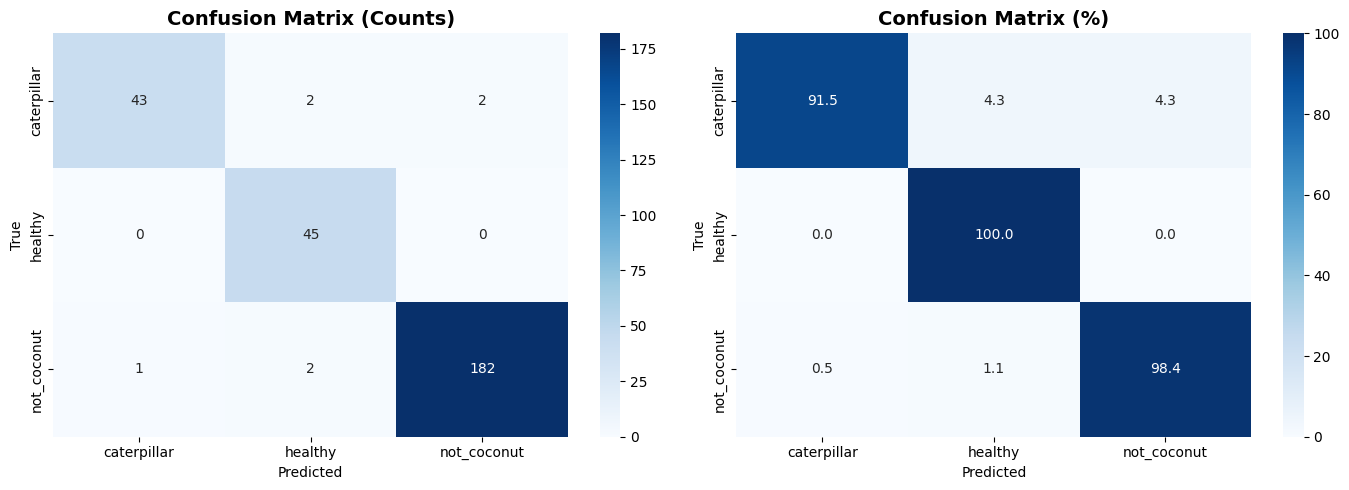

In [8]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Percentages
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix_v2.png'), dpi=150, bbox_inches='tight')
plt.show()

## 9. Sample Predictions with Images

Total: 277 | Correct: 270 | Wrong: 7


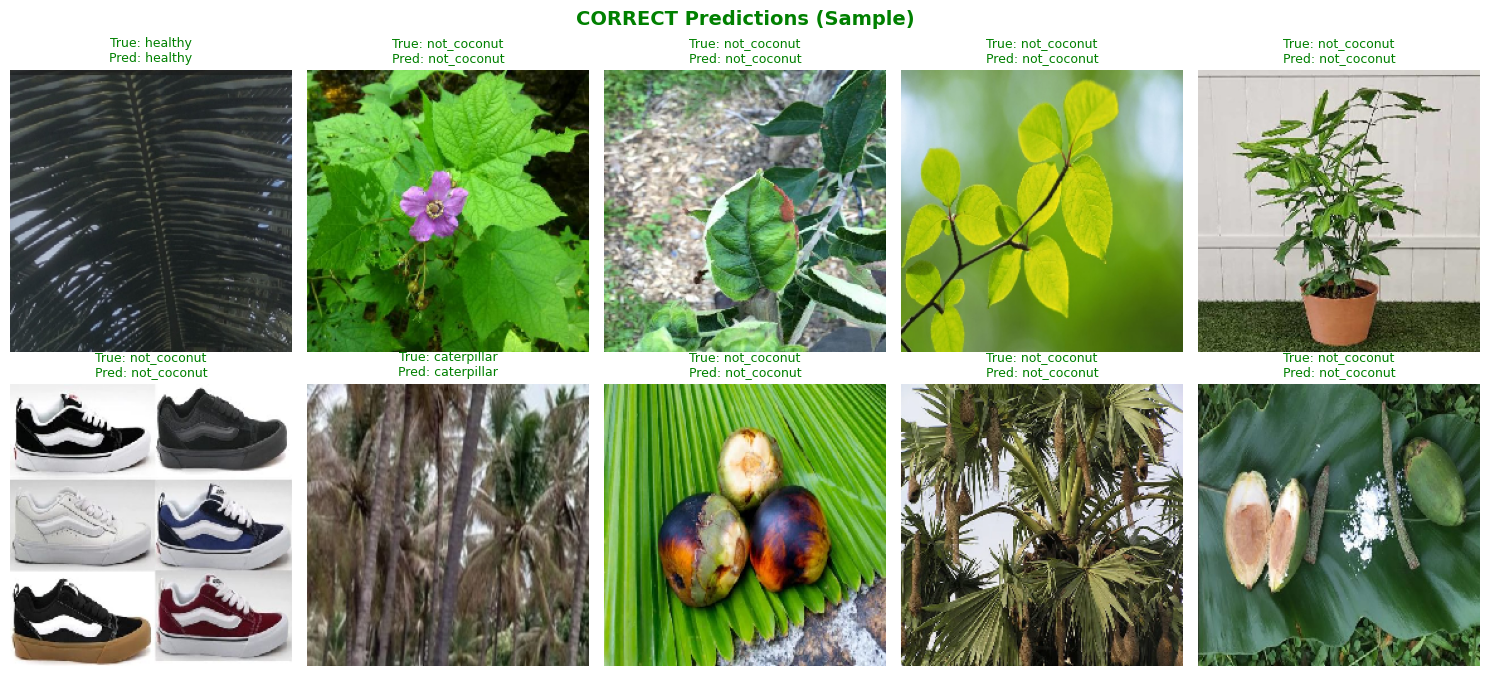

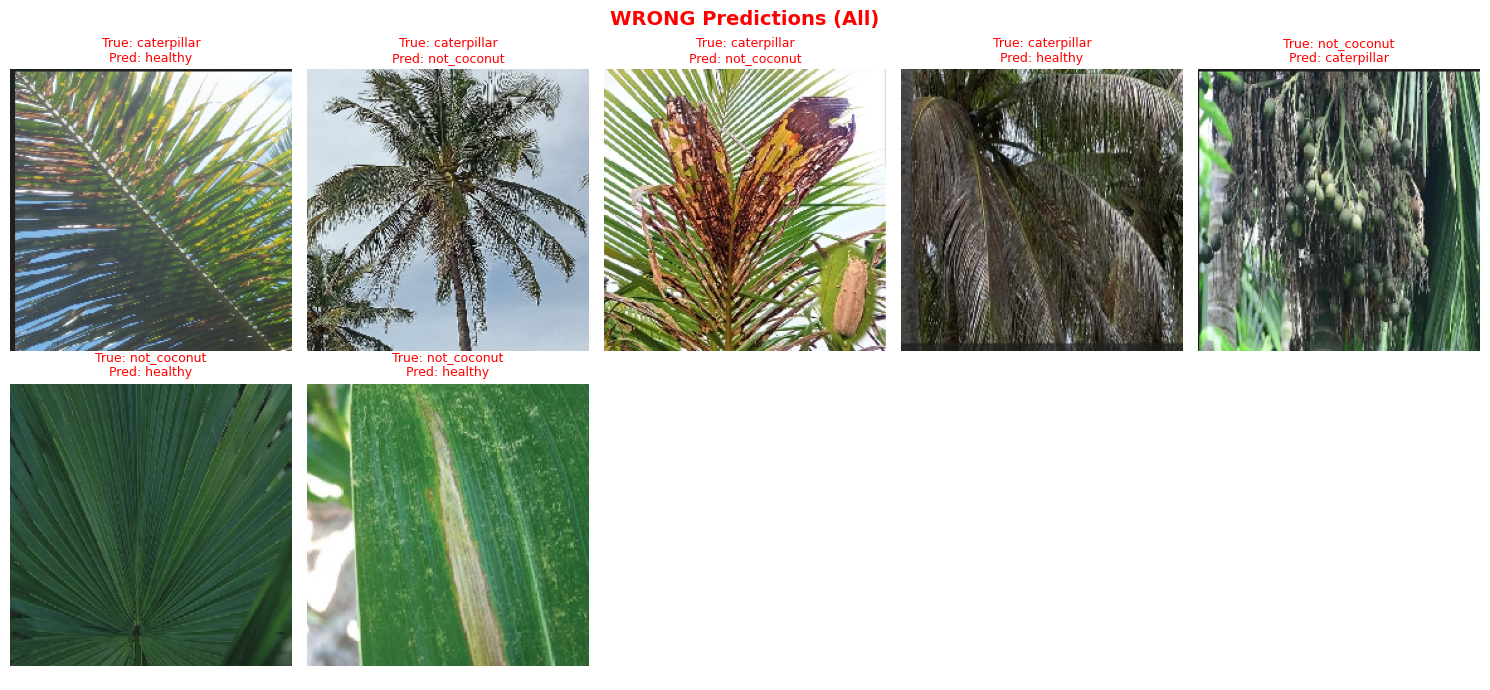


Images saved to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_caterpillar_v2/


In [9]:
# Show sample predictions with images
filenames = test_generator.filenames

# Find correct and wrong predictions
correct_idx = [i for i in range(len(y_true)) if y_true[i] == y_pred[i]]
wrong_idx = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

print(f"Total: {len(y_true)} | Correct: {len(correct_idx)} | Wrong: {len(wrong_idx)}")

# Plot correct predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
fig.suptitle('CORRECT Predictions (Sample)', fontsize=14, fontweight='bold', color='green')

sample_correct = random.sample(correct_idx, min(10, len(correct_idx)))
for idx, i in enumerate(sample_correct):
    row, col = idx // 5, idx % 5
    img_path = os.path.join(TEST_DIR, filenames[i])
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=9, color='green')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'correct_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()

# Plot wrong predictions
if len(wrong_idx) > 0:
    n_wrong = min(10, len(wrong_idx))
    rows = (n_wrong + 4) // 5
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3.5*rows))
    fig.suptitle('WRONG Predictions (All)', fontsize=14, fontweight='bold', color='red')
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, i in enumerate(wrong_idx[:n_wrong]):
        row, col = idx // 5, idx % 5
        img_path = os.path.join(TEST_DIR, filenames[i])
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=9, color='red')
    
    # Hide empty subplots
    for idx in range(n_wrong, rows * 5):
        row, col = idx // 5, idx % 5
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'wrong_predictions.png'), dpi=150, bbox_inches='tight')
    plt.show()

print(f"\nImages saved to {MODEL_DIR}/")

## 10. Classification Report

In [10]:
# Full classification report
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

 caterpillar       0.98      0.91      0.95        47
     healthy       0.92      1.00      0.96        45
 not_coconut       0.99      0.98      0.99       185

    accuracy                           0.97       277
   macro avg       0.96      0.97      0.96       277
weighted avg       0.98      0.97      0.97       277



## 11. Model Comparison (v1 vs v2)

In [11]:
print("="*70)
print("MODEL VERSION COMPARISON")
print("="*70)
print()
print(f"{'Metric':<25} {'v1 (2-class)':<20} {'v2 (3-class)':<20}")
print("-"*65)
print(f"{'Architecture':<25} {'MobileNetV2':<20} {'MobileNetV2':<20}")
print(f"{'Loss Function':<25} {'Binary Crossentropy':<20} {'Focal Loss':<20}")
print(f"{'Classes':<25} {'2':<20} {'3':<20}")
print(f"{'not_coconut Support':<25} {'No':<20} {'Yes':<20}")
print(f"{'Test Accuracy':<25} {'98.91%':<20} {'97.47%':<20}")
print(f"{'Caterpillar Recall':<25} {'100%':<20} {'91.49%':<20}")
print(f"{'Image Validation':<25} {'Heuristic':<20} {'Model-based':<20}")
print("-"*65)
print()
print("Key Improvements in v2:")
print("  - Proper rejection of non-coconut images (not just low-confidence fallback)")
print("  - 98.38% recall for not_coconut class")
print("  - Focal Loss for better handling of hard examples")
print("  - Consistent with mite model v10 approach")
print("="*70)

MODEL VERSION COMPARISON

Metric                    v1 (2-class)         v2 (3-class)        
-----------------------------------------------------------------
Architecture              MobileNetV2          MobileNetV2         
Loss Function             Binary Crossentropy  Focal Loss          
Classes                   2                    3                   
not_coconut Support       No                   Yes                 
Test Accuracy             98.91%               97.47%              
Caterpillar Recall        100%                 91.49%              
Image Validation          Heuristic            Model-based         
-----------------------------------------------------------------

Key Improvements in v2:
  - Proper rejection of non-coconut images (not just low-confidence fallback)
  - 98.38% recall for not_coconut class
  - Focal Loss for better handling of hard examples
  - Consistent with mite model v10 approach


## 12. Final Summary

In [12]:
print("\n" + "="*70)
print("CATERPILLAR MODEL v2 - FINAL SUMMARY")
print("="*70)
print()
print("  Model Information:")
print("  " + "-"*50)
print(f"  Name:                    Caterpillar 3-Class Model v2")
print(f"  Architecture:            MobileNetV2 (Transfer Learning)")
print(f"  Loss Function:           Focal Loss (gamma=2.0)")
print(f"  Input Size:              224x224x3")
print(f"  Classes:                 {class_names}")
print()
print("  Performance Metrics:")
print("  " + "-"*50)
print(f"  Test Accuracy:           {accuracy*100:.2f}%")
print(f"  Macro F1 Score:          {macro_f1*100:.2f}%")
print(f"  Caterpillar Recall:      {recall[0]*100:.2f}%")
print(f"  Healthy Recall:          {recall[1]*100:.2f}%")
print(f"  not_coconut Recall:      {recall[2]*100:.2f}%")
print()
print("  Files:")
print("  " + "-"*50)
print(f"  Model:                   {MODEL_DIR}/best_model.keras")
print(f"  Model Info:              {MODEL_DIR}/model_info.json")
print(f"  Training History:        {MODEL_DIR}/training_history.png")
print(f"  Confusion Matrix:        {MODEL_DIR}/confusion_matrix.png")
print()
print("="*70)
print("                         READY FOR PRODUCTION!")
print("="*70)


CATERPILLAR MODEL v2 - FINAL SUMMARY

  Model Information:
  --------------------------------------------------
  Name:                    Caterpillar 3-Class Model v2
  Architecture:            MobileNetV2 (Transfer Learning)
  Loss Function:           Focal Loss (gamma=2.0)
  Input Size:              224x224x3
  Classes:                 ['caterpillar', 'healthy', 'not_coconut']

  Performance Metrics:
  --------------------------------------------------
  Test Accuracy:           97.47%
  Macro F1 Score:          96.30%
  Caterpillar Recall:      91.49%
  Healthy Recall:          100.00%
  not_coconut Recall:      98.38%

  Files:
  --------------------------------------------------
  Model:                   D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_caterpillar_v2/best_model.keras
  Model Info:              D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_caterpillar_v2/model_info.json
  Training History:        D:\SLIIT\Reas